In [1]:
import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)  # Seed 고정

## 데이터 불러오기

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [49]:
data = pd.read_csv('../../ssd_data/final_data/final_MB1_30.csv')
# 'index' 컬럼을 datetime 형태로 변환
data['index'] = pd.to_datetime(data['index'])

data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,6653.0,100.0,0.0,97.0,12707.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,4.976439e+10,99.0,3.939800e+10,0.0
1,2019-01-02,6653.0,100.0,0.0,97.0,12731.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.034821e+10,99.0,3.956458e+10,0.0
2,2019-01-03,6653.0,100.0,0.0,97.0,12755.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.082254e+10,99.0,3.973763e+10,0.0
3,2019-01-04,6653.0,100.0,0.0,97.0,12779.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.121309e+10,99.0,3.990997e+10,0.0
4,2019-01-05,6653.0,100.0,0.0,97.0,12803.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.157860e+10,99.0,4.008257e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71973,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,1.0
71974,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,1.0
71975,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,1.0
71976,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,1.0


In [50]:
data['disk_id'].unique().shape

(488,)

In [51]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

label_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)
label_1

,disk_id
0,470.0
1,476.0
2,531.0
3,601.0
4,609.0
...,...
239,43760.0
240,44325.0
241,44330.0
242,44335.0


In [52]:
import numpy as np
def create_sequences(data, window_size):
    X = []
    y = []

    # 각 disk_id에 대해 처리
    for disk_id in data['disk_id'].unique():
        disk_data = data[data['disk_id'] == disk_id].sort_values('index')  # index로 정렬
        disk_values = disk_data.drop(columns=['disk_id', 'index']).values  # 'disk_id'와 'index' 컬럼을 제외하고 numpy array로 변환

        # 이 disk_id에 대해 시퀀스 생성
        for i in range(len(disk_values) - window_size):
            X.append(disk_values[i:i + window_size, :-1])  # 마지막 차원은 특성(feature)을 의미합니다. 마지막 열('fail')을 제외합니다.
            y.append(disk_values[i + window_size -1, -1])  # 예를 들어 'fail' 상태가 마지막 특성일 경우입니다.

    return np.array(X), np.array(y)

## dataset 만들기

In [53]:
label_1.shape

(244, 1)

In [54]:
disk_list = list(data['disk_id'].drop_duplicates())
failure_disk_list = list(label_1.values.squeeze())
healthy_disk_list = list(set(disk_list) - set(failure_disk_list))

In [58]:
import random
random.seed(42)

# 195개씩 랜덤하게 선택
healthy_disk_195 = random.sample(healthy_disk_list, 195)
failure_disk_195 = random.sample(failure_disk_list, 195)

print(len(healthy_disk_195))
print(len(failure_disk_195))

# 195개에서 146/49 개로 validation set 구축
healthy_disk_146 = random.sample(healthy_disk_195,146) #train set
healthy_disk_49 = list(set(healthy_disk_195) - set(healthy_disk_146)) #validation set

failure_disk_146 = random.sample(failure_disk_195, 146) #train set
failure_disk_49 = list(set(failure_disk_195) - set(failure_disk_146)) #validation set

print('train_healthy_count:', len(healthy_disk_146))
print('train_failure_count:', len(failure_disk_146))

print('val_healthy_count:', len(healthy_disk_49))
print('val_failure_count:',len(failure_disk_49))
# 49개씩 랜덤하게 선택
test_healthy_disk_49 = list(set(healthy_disk_list) - set(healthy_disk_195)) # test set
test_failure_disk_49 = list(set(failure_disk_list) - set(failure_disk_195)) # test set

print('test_healthy_count:',len(test_healthy_disk_49))
print('test_healthy_count:',len(test_failure_disk_49))

195
195
train_healthy_count: 146
train_failure_count: 146
val_healthy_count: 49
val_failure_count: 49
test_healthy_count: 49
test_healthy_count: 49


In [60]:
H_disk_195 = data[data['disk_id'].isin(healthy_disk_195)]
F_disk_195 = data[data['disk_id'].isin(failure_disk_195)]

H_disk_146 = data[data['disk_id'].isin(healthy_disk_146)]
F_disk_146 = data[data['disk_id'].isin(failure_disk_146)]

H_disk_49 = data[data['disk_id'].isin(healthy_disk_49)]
F_disk_49 = data[data['disk_id'].isin(failure_disk_49)]

test_H_disk_49 = data[data['disk_id'].isin(test_healthy_disk_49)]
test_F_disk_49 = data[data['disk_id'].isin(test_failure_disk_49)]

# train set, validation set, test set 생성
#final_train_set = pd.concat([H_disk_195,F_disk_195],ignore_index=True,axis=0) #validation set으로 최적의 epoch 찾은 후, 해당 epoch으로 다시 training 시킬 예정
train_set = pd.concat([H_disk_146,F_disk_146],ignore_index=True,axis=0)
val_set = pd.concat([H_disk_49,F_disk_49],ignore_index=True,axis=0)
test_set = pd.concat([test_H_disk_49,test_F_disk_49],ignore_index=True,axis=0)

In [61]:
# feature와 label 구분
#final_X_train = final_train_set.drop(columns=['disk_id','index','label'])
X_train = train_set.drop(columns=['disk_id','index','label'])
X_val = val_set.drop(columns=['disk_id','index','label'])
X_test = test_set.drop(columns=['disk_id','index','label'])

#final_y_train = final_train_set['label']
y_train = train_set['label']
y_val = val_set['label']
y_test = test_set['label']

## LSTM vs Conv+LSTM (window_size = 30)

### LSTM

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
val_scaled = pd.concat([val_set[['disk_id','index']],X_val_scaled_df, y_val], axis=1)
test_scaled = pd.concat([test_set[['disk_id','index']],X_test_scaled_df, y_test], axis=1)

In [63]:
window_size = 30 # 10일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)

(34058, 30, 32)
(11308, 30, 32)
(11972, 30, 32)
(34058,)
(11308,)
(11972,)


In [64]:
def LSTM_model(timestep):
    # LSTM 모델 정의
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(timestep, 32)))  # n_features는 특성의 수
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

    return model

In [65]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = LSTM_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1064/1065 [============================>.] - ETA: 0s - loss: 0.3414 - acc: 0.8839
Epoch 1: val_loss improved from inf to 0.31441, saving model to best_model.h5
1065/1065 [==============================] - 11s 8ms/step - loss: 0.3413 - acc: 0.8840 - val_loss: 0.3144 - val_acc: 0.8862
Epoch 2/20
  21/1065 [..............................] - ETA: 8s - loss: 0.3363 - acc: 0.8750

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1059/1065 [============================>.] - ETA: 0s - loss: 0.3178 - acc: 0.8839
Epoch 2: val_loss improved from 0.31441 to 0.31289, saving model to best_model.h5
1065/1065 [==============================] - 8s 8ms/step - loss: 0.3174 - acc: 0.8841 - val_loss: 0.3129 - val_acc: 0.8906
Epoch 3/20
1064/1065 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.8892
Epoch 3: val_loss improved from 0.31289 to 0.29132, saving model to best_model.h5
1065/1065 [==============================] - 9s 8ms/step - loss: 0.2950 - acc: 0.8892 - val_loss: 0.2913 - val_acc: 0.8796
Epoch 4/20
1062/1065 [============================>.] - ETA: 0s - loss: 0.3607 - acc: 0.8886
Epoch 4: val_loss did not improve from 0.29132
1065/1065 [==============================] - 10s 9ms/step - loss: 0.3604 - acc: 0.8887 - val_loss: 0.3197 - val_acc: 0.8862
Epoch 5/20
1065/1065 [==============================] - ETA: 0s - loss: 0.3038 - acc: 0.8856
Epoch 5: val_loss did not improve from 0.29132
1065/1065 [

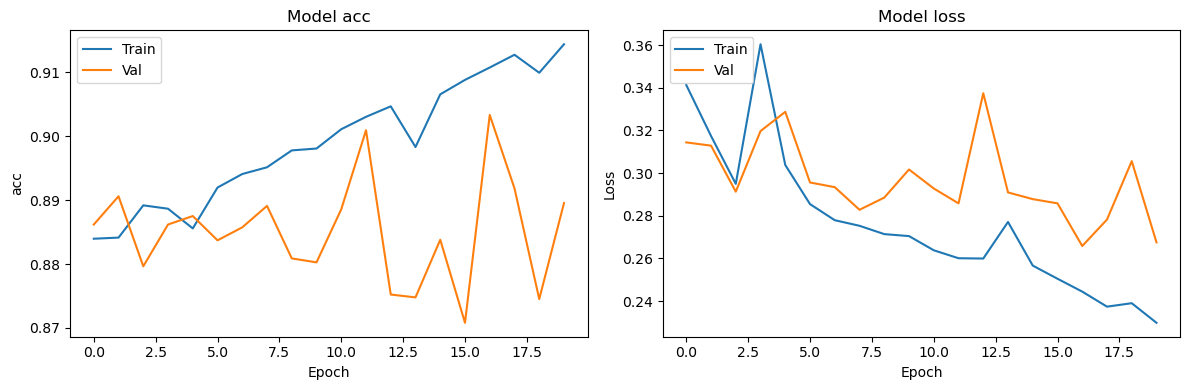

In [66]:
import matplotlib.pyplot as plt

# Plot training & validation acc values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [67]:
from keras.models import load_model

# LSTM 모델 정의
best_model = LSTM_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

375/375 [==============================] - 1s 3ms/step - loss: 0.2658 - acc: 0.8905


[0.265849769115448, 0.8904944658279419]

In [68]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

375/375 [==============================] - 1s 3ms/step
Macro F1 Score: 0.6894118317543828


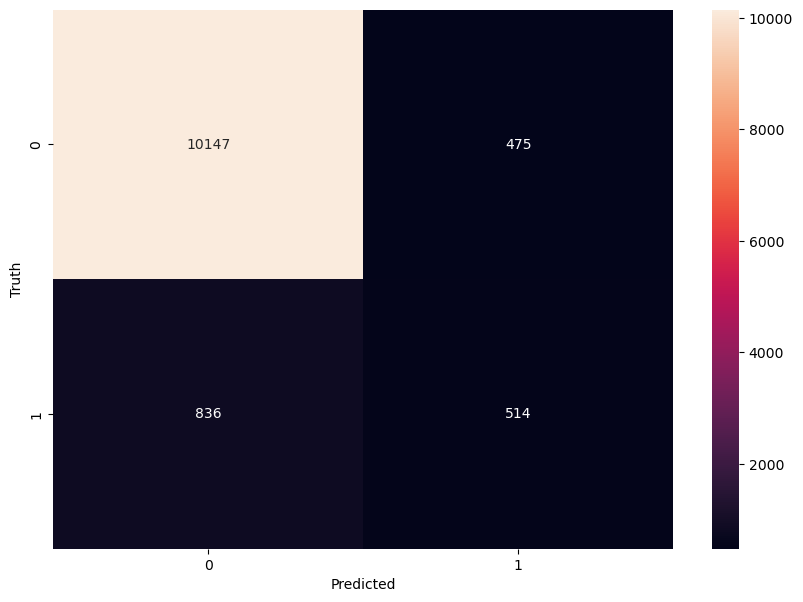

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [70]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11972,)
Number of ones in y_test_window: 1350


375/375 [==============================] - 1s 3ms/step


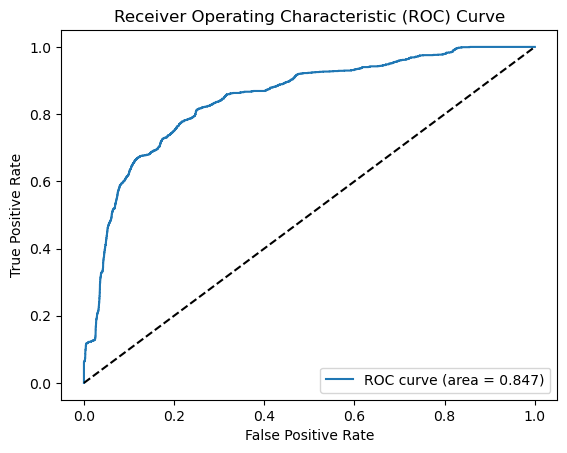

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [72]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

375/375 [==============================] - 1s 3ms/step
Best Threshold=0.064700, Sensitivity=0.813, Specificity=0.749, J=0.563
              precision    recall  f1-score   support

     healthy       0.97      0.75      0.85     10622
     failure       0.29      0.81      0.43      1350

    accuracy                           0.76     11972
   macro avg       0.63      0.78      0.64     11972
weighted avg       0.89      0.76      0.80     11972



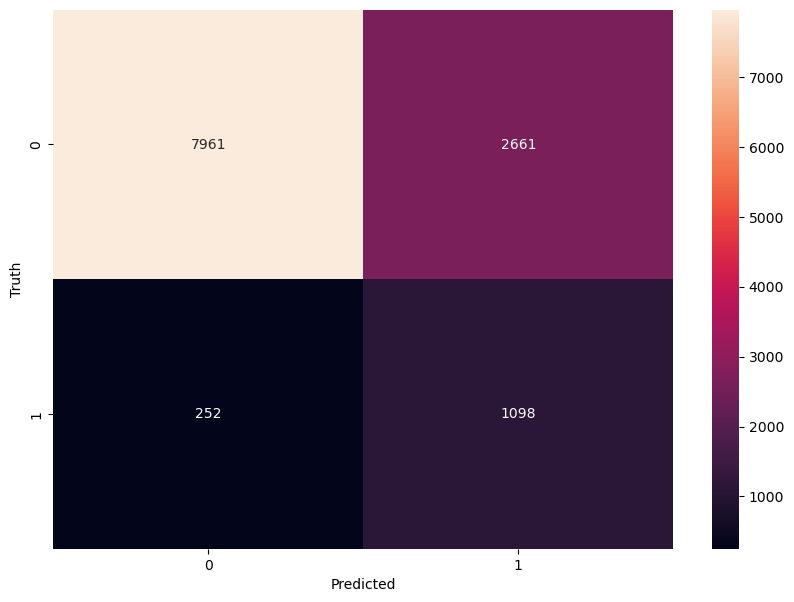

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Conv 1D + LSTM

In [77]:
window_size = 30 # 10일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)


(34058, 30, 32)
(11308, 30, 32)
(11972, 30, 32)
(34058,)
(11308,)
(11972,)


In [75]:
#X_train_window = X_train_window.reshape(X_train_window.shape[0], 3, 10, X_train_window.shape[2])
#X_val_window = X_val_window.reshape(X_val_window.shape[0], 3, 10, X_val_window.shape[2])
#X_test_window = X_test_window.reshape(X_test_window.shape[0], 3, 10, X_test_window.shape[2])

In [76]:
#print(X_train_window.shape)
#print(X_val_window.shape)
#print(X_test_window.shape)

(34058, 3, 10, 32)
(11308, 3, 10, 32)
(11972, 3, 10, 32)


In [93]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout


def Conv1d_LSTM_model(timestep):
    # 모델 정의
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(Conv1D(filters=32, kernel_size=3, activation='relu' ,input_shape=(timestep, 32)))
    model_cnn_lstm.add(MaxPooling1D(pool_size=2))
    #model_cnn_lstm.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    #model_cnn_lstm.add((Dropout(0.5))
    #model_cnn_lstm.add(MaxPooling1D(pool_size=2))
    model_cnn_lstm.add(LSTM(32, activation='relu'))
    model_cnn_lstm.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model_cnn_lstm.add(Dropout(0.5))
    model_cnn_lstm.add(Dense(1, activation='sigmoid'))


    # 모델 컴파일
    model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model_cnn_lstm

In [95]:
model = Conv1d_LSTM_model(30)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 28, 32)            3104      
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 14, 32)            0         
 ng1D)                                                           
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_22 (Dense)            (None, 32)                1056      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12513 (48.88 KB)
Trainable params: 12513 (48.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [96]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('conv_lstm_30_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = Conv1d_LSTM_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1062/1065 [============================>.] - ETA: 0s - loss: 0.3472 - accuracy: 0.8835
Epoch 1: val_loss improved from inf to 0.32771, saving model to conv_lstm_30_best_model.h5
1065/1065 [==============================] - 7s 6ms/step - loss: 0.3470 - accuracy: 0.8836 - val_loss: 0.3277 - val_accuracy: 0.8862
Epoch 2/20
  29/1065 [..............................] - ETA: 5s - loss: 0.3412 - accuracy: 0.8804

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1063/1065 [============================>.] - ETA: 0s - loss: 0.3204 - accuracy: 0.8842
Epoch 2: val_loss improved from 0.32771 to 0.29538, saving model to conv_lstm_30_best_model.h5
1065/1065 [==============================] - 6s 6ms/step - loss: 0.3202 - accuracy: 0.8843 - val_loss: 0.2954 - val_accuracy: 0.8862
Epoch 3/20
1064/1065 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8891
Epoch 3: val_loss improved from 0.29538 to 0.28951, saving model to conv_lstm_30_best_model.h5
1065/1065 [==============================] - 6s 6ms/step - loss: 0.2969 - accuracy: 0.8891 - val_loss: 0.2895 - val_accuracy: 0.8781
Epoch 4/20
1055/1065 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8924
Epoch 4: val_loss improved from 0.28951 to 0.28544, saving model to conv_lstm_30_best_model.h5
1065/1065 [==============================] - 6s 6ms/step - loss: 0.2860 - accuracy: 0.8925 - val_loss: 0.2854 - val_accuracy: 0.8787
Epoch 5/20
1060/1065 [===========

In [98]:
from keras.models import load_model

best_model = Conv1d_LSTM_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('conv_lstm_30_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

375/375 [==============================] - 1s 3ms/step - loss: 0.2730 - accuracy: 0.8938


[0.2729801833629608, 0.8937520980834961]

In [99]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

375/375 [==============================] - 1s 2ms/step
Macro F1 Score: 0.7206672824011178


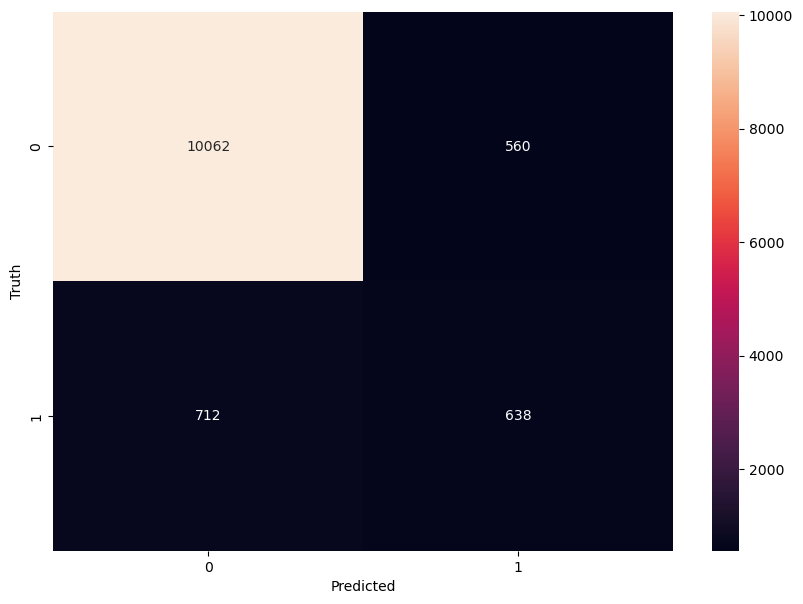

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [101]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11972,)
Number of ones in y_test_window: 1350


  1/375 [..............................] - ETA: 8s

375/375 [==============================] - 1s 2ms/step


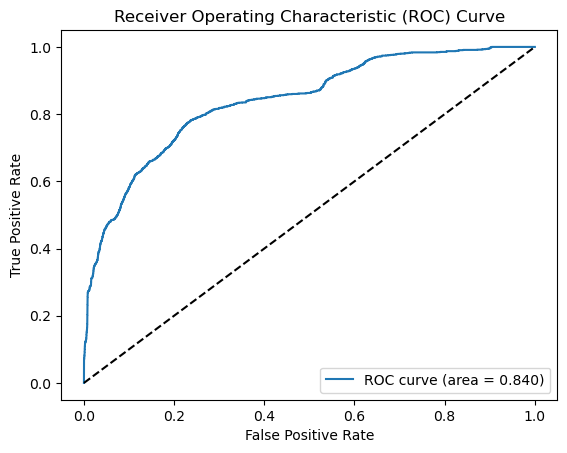

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [103]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

375/375 [==============================] - 1s 2ms/step
Best Threshold=0.096447, Sensitivity=0.781, Specificity=0.764, J=0.545
              precision    recall  f1-score   support

     healthy       0.96      0.76      0.85     10622
     failure       0.30      0.78      0.43      1350

    accuracy                           0.77     11972
   macro avg       0.63      0.77      0.64     11972
weighted avg       0.89      0.77      0.81     11972



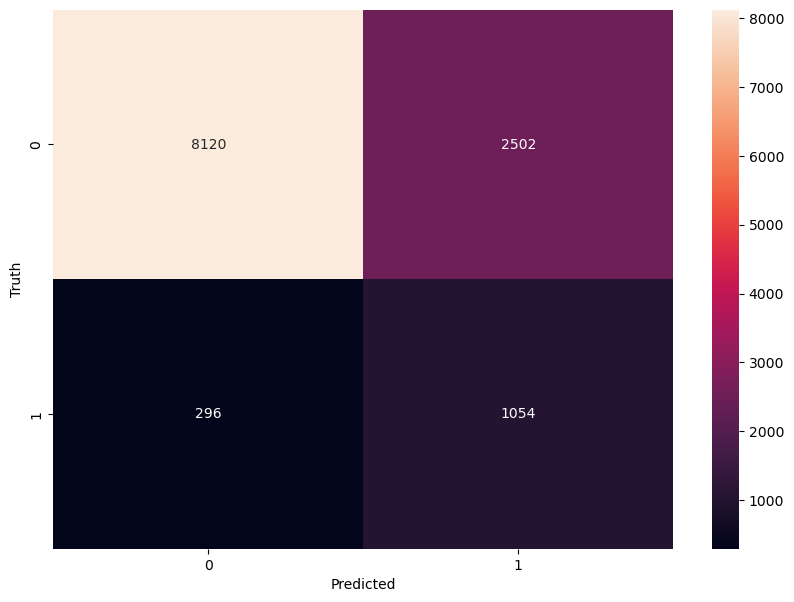

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## LSTM vs Conv1d + LSTM(window_size=90)

### LSTM (window = 90)

In [134]:
window_size = 90 # 90일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)

(19228, 90, 32)
(4719, 90, 32)
(5888, 90, 32)
(19228,)
(4719,)
(5888,)


In [135]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('lstm_90_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = LSTM_model(90)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
601/601 [==============================] - ETA: 0s - loss: 0.3707 - acc: 0.8626
Epoch 1: val_loss improved from inf to 0.31149, saving model to lstm_90_best_model.h5
601/601 [==============================] - 15s 23ms/step - loss: 0.3707 - acc: 0.8626 - val_loss: 0.3115 - val_acc: 0.8739
Epoch 2/20
  7/601 [..............................] - ETA: 12s - loss: 0.4543 - acc: 0.8214

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/601 [============================>.] - ETA: 0s - loss: 0.3274 - acc: 0.8720
Epoch 2: val_loss improved from 0.31149 to 0.29969, saving model to lstm_90_best_model.h5
601/601 [==============================] - 13s 22ms/step - loss: 0.3276 - acc: 0.8718 - val_loss: 0.2997 - val_acc: 0.8729
Epoch 3/20
599/601 [============================>.] - ETA: 0s - loss: 170.6432 - acc: 0.8689
Epoch 3: val_loss did not improve from 0.29969
601/601 [==============================] - 13s 22ms/step - loss: 170.1116 - acc: 0.8691 - val_loss: 0.3422 - val_acc: 0.8739
Epoch 4/20
601/601 [==============================] - ETA: 0s - loss: 0.3514 - acc: 0.8650
Epoch 4: val_loss did not improve from 0.29969
601/601 [==============================] - 13s 22ms/step - loss: 0.3514 - acc: 0.8650 - val_loss: 0.3417 - val_acc: 0.8673
Epoch 5/20
599/601 [============================>.] - ETA: 0s - loss: 0.3297 - acc: 0.8646
Epoch 5: val_loss improved from 0.29969 to 0.29483, saving model to lstm_90_best_model.h5


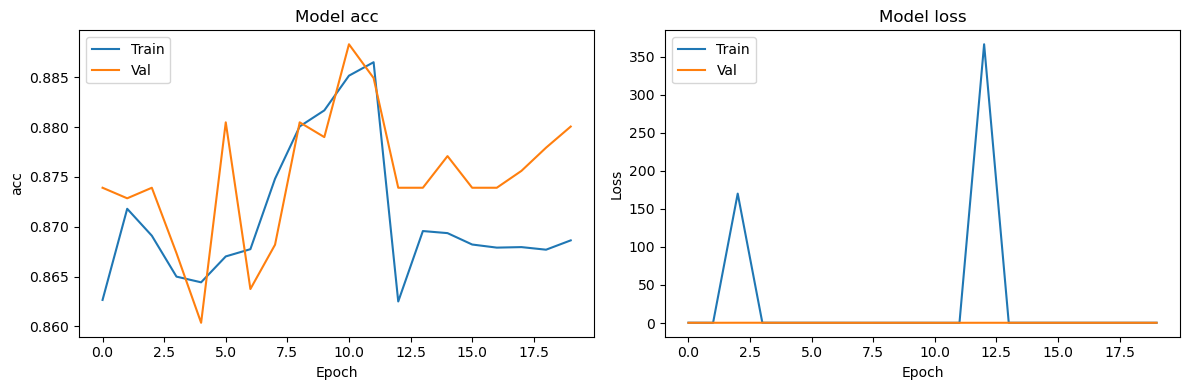

In [136]:
import matplotlib.pyplot as plt

# Plot training & validation acc values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [137]:
from keras.models import load_model

# LSTM 모델 정의
best_model = LSTM_model(90)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('lstm_90_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

184/184 [==============================] - 2s 8ms/step - loss: 0.2625 - acc: 0.8811


[0.2625022530555725, 0.88111412525177]

In [138]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

184/184 [==============================] - 2s 9ms/step
Macro F1 Score: 0.6365317994109868


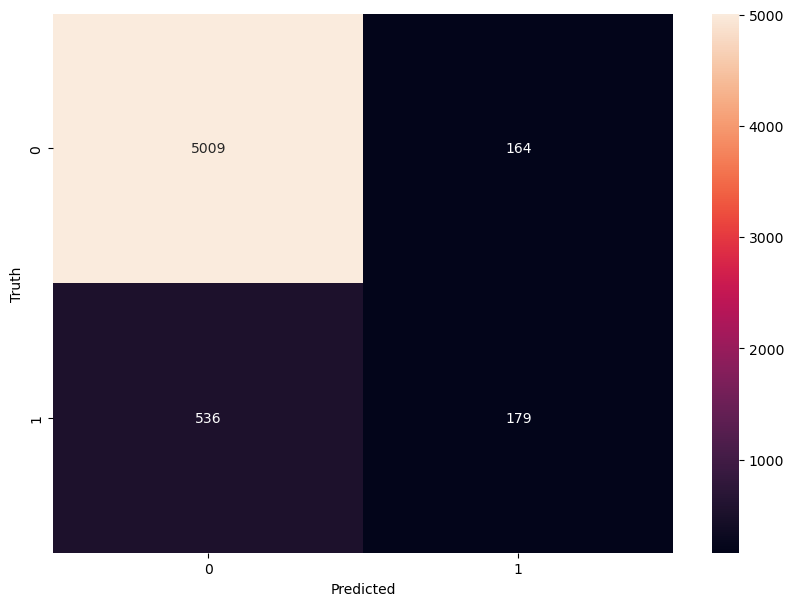

In [139]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [140]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(5888,)
Number of ones in y_test_window: 715


184/184 [==============================] - 2s 8ms/step


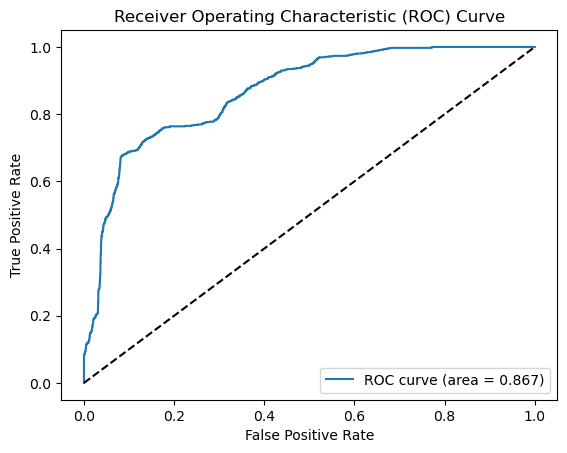

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [142]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

184/184 [==============================] - 1s 7ms/step
Best Threshold=0.277248, Sensitivity=0.677, Specificity=0.916, J=0.593
              precision    recall  f1-score   support

     healthy       0.95      0.92      0.93      5173
     failure       0.53      0.68      0.59       715

    accuracy                           0.89      5888
   macro avg       0.74      0.80      0.76      5888
weighted avg       0.90      0.89      0.89      5888



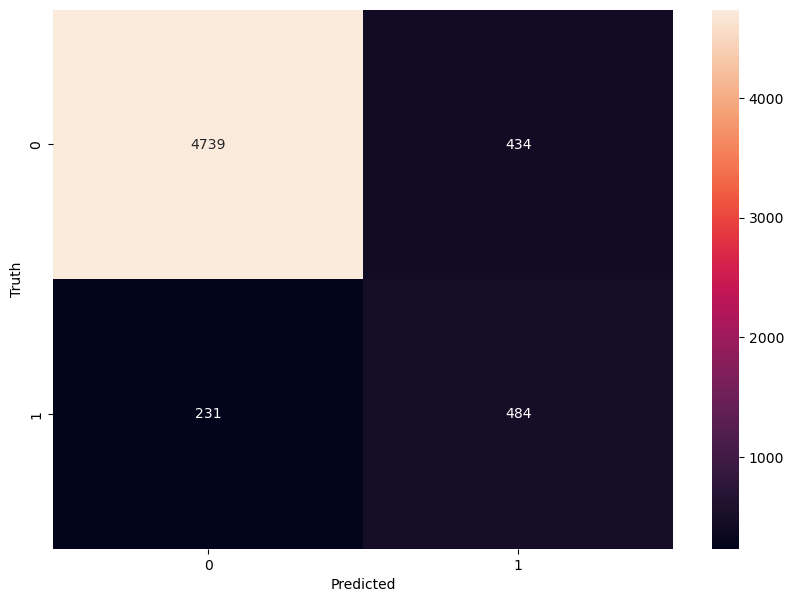

In [143]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Conv1D + LSTM (window_size=90)

In [144]:
X_train_window = X_train_window.reshape(X_train_window.shape[0], 3, 30, X_train_window.shape[2])
X_val_window = X_val_window.reshape(X_val_window.shape[0], 3, 30, X_val_window.shape[2])
X_test_window = X_test_window.reshape(X_test_window.shape[0], 3, 30, X_test_window.shape[2])

In [145]:
print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

(19228, 3, 30, 32)
(4719, 3, 30, 32)
(5888, 3, 30, 32)


In [146]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('conv_lstm_90_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = Conv1d_LSTM_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
598/601 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8615
Epoch 1: val_loss improved from inf to 0.29946, saving model to conv_lstm_90_best_model.h5
601/601 [==============================] - 6s 6ms/step - loss: 0.3659 - accuracy: 0.8613 - val_loss: 0.2995 - val_accuracy: 0.8739
Epoch 2/20
 28/601 [>.............................] - ETA: 3s - loss: 0.3572 - accuracy: 0.8560

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


597/601 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.8660
Epoch 2: val_loss did not improve from 0.29946
601/601 [==============================] - 4s 6ms/step - loss: 0.3275 - accuracy: 0.8659 - val_loss: 0.3035 - val_accuracy: 0.8739
Epoch 3/20
593/601 [============================>.] - ETA: 0s - loss: 0.3153 - accuracy: 0.8658
Epoch 3: val_loss did not improve from 0.29946
601/601 [==============================] - 3s 5ms/step - loss: 0.3158 - accuracy: 0.8660 - val_loss: 0.3100 - val_accuracy: 0.8739
Epoch 4/20
597/601 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8659
Epoch 4: val_loss did not improve from 0.29946
601/601 [==============================] - 3s 5ms/step - loss: 0.3094 - accuracy: 0.8663 - val_loss: 0.3119 - val_accuracy: 0.8739
Epoch 5/20
597/601 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8675
Epoch 5: val_loss improved from 0.29946 to 0.29156, saving model to conv_lstm_90_best_model.h

In [147]:
from keras.models import load_model

best_model = Conv1d_LSTM_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('conv_lstm_90_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

184/184 [==============================] - 1s 2ms/step - loss: 0.3059 - accuracy: 0.8905


[0.305850088596344, 0.8904551863670349]

In [148]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

184/184 [==============================] - 1s 2ms/step
Macro F1 Score: 0.7361115405688137


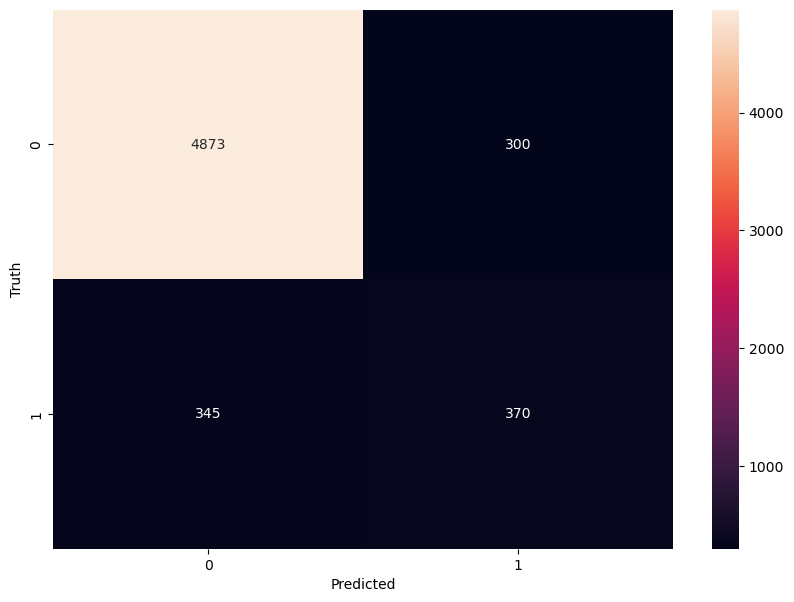

In [149]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [150]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(5888,)
Number of ones in y_test_window: 715


184/184 [==============================] - 0s 2ms/step


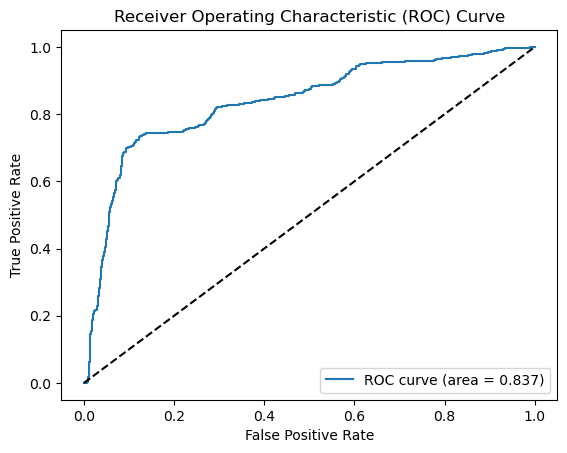

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [152]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

184/184 [==============================] - 0s 2ms/step
Best Threshold=0.155286, Sensitivity=0.734, Specificity=0.876, J=0.610
              precision    recall  f1-score   support

     healthy       0.96      0.88      0.92      5173
     failure       0.45      0.73      0.56       715

    accuracy                           0.86      5888
   macro avg       0.70      0.80      0.74      5888
weighted avg       0.90      0.86      0.87      5888



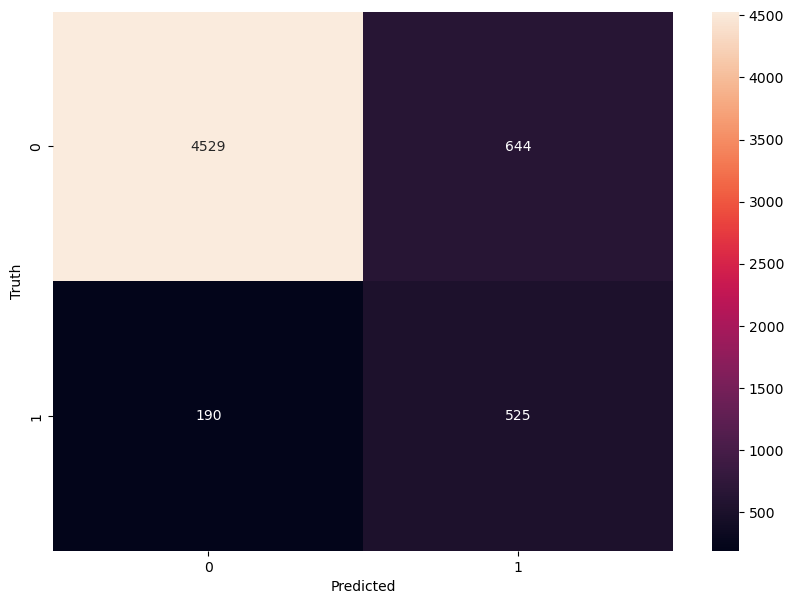

In [153]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## LSTM + Attention vs Conv1D + LSTM + Attention (window_size = 30)

### LSTM + Attention(windwo_size=30)

In [123]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
val_scaled = pd.concat([val_set[['disk_id','index']],X_val_scaled_df, y_val], axis=1)
test_scaled = pd.concat([test_set[['disk_id','index']],X_test_scaled_df, y_test], axis=1)

In [124]:
window_size = 30 # 10일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)

(34058, 30, 32)
(11308, 30, 32)
(11972, 30, 32)
(34058,)
(11308,)
(11972,)


In [125]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, timesteps, **kwargs):
        self.timesteps = timesteps
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(self.timesteps, 1),
                               initializer="zeros")     
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x*at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config.update({"timesteps": self.timesteps})
        return base_config

In [126]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

def LSTM_Att_model(timestep):
    inputs = Input(shape=(timestep, 32))
    lstm_out = LSTM(32, return_sequences=True)(inputs)
    attention_out = Attention(30)(lstm_out)
    x = Dense(32,  kernel_regularizer=regularizers.l2(0.001))(attention_out)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [127]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('LSTM_Att_30_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = LSTM_Att_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1060/1065 [============================>.] - ETA: 0s - loss: 0.3501 - accuracy: 0.8838
Epoch 1: val_loss improved from inf to 0.32034, saving model to LSTM_Att_30_best_model.h5
1065/1065 [==============================] - 12s 10ms/step - loss: 0.3499 - accuracy: 0.8839 - val_loss: 0.3203 - val_accuracy: 0.8814
Epoch 2/20
  20/1065 [..............................] - ETA: 8s - loss: 0.3281 - accuracy: 0.8828

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1062/1065 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8884
Epoch 2: val_loss improved from 0.32034 to 0.31110, saving model to LSTM_Att_30_best_model.h5
1065/1065 [==============================] - 10s 9ms/step - loss: 0.3021 - accuracy: 0.8886 - val_loss: 0.3111 - val_accuracy: 0.8906
Epoch 3/20
1063/1065 [============================>.] - ETA: 0s - loss: 0.2812 - accuracy: 0.8959
Epoch 3: val_loss improved from 0.31110 to 0.28259, saving model to LSTM_Att_30_best_model.h5
1065/1065 [==============================] - 9s 9ms/step - loss: 0.2812 - accuracy: 0.8958 - val_loss: 0.2826 - val_accuracy: 0.8813
Epoch 4/20
1061/1065 [============================>.] - ETA: 0s - loss: 0.2698 - accuracy: 0.8991
Epoch 4: val_loss did not improve from 0.28259
1065/1065 [==============================] - 9s 9ms/step - loss: 0.2696 - accuracy: 0.8993 - val_loss: 0.2996 - val_accuracy: 0.8796
Epoch 5/20
1062/1065 [============================>.] - ETA: 0s - loss: 0.2600 - a

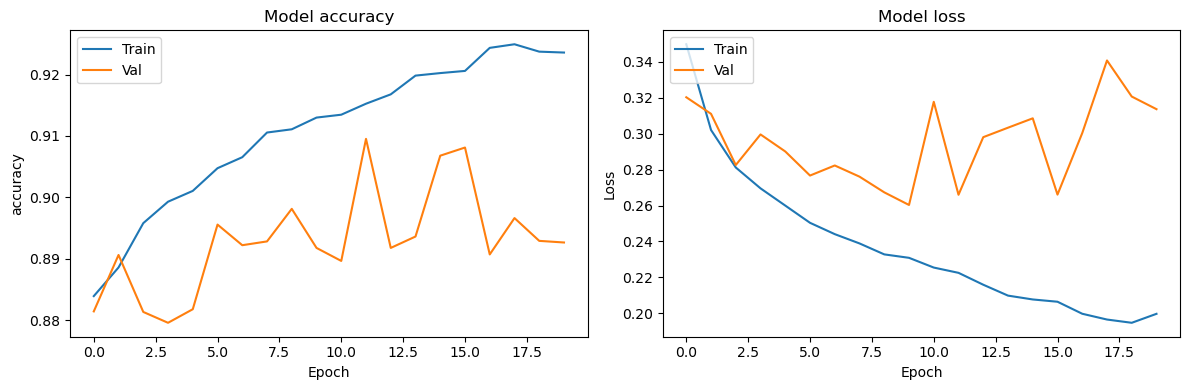

In [128]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [129]:
from keras.models import load_model

# LSTM 모델 정의
best_model = LSTM_Att_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('LSTM_Att_30_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

375/375 [==============================] - 2s 3ms/step - loss: 0.2699 - accuracy: 0.8887


[0.26987773180007935, 0.8886568546295166]

In [130]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

375/375 [==============================] - 2s 3ms/step
Macro F1 Score: 0.6651615520781083


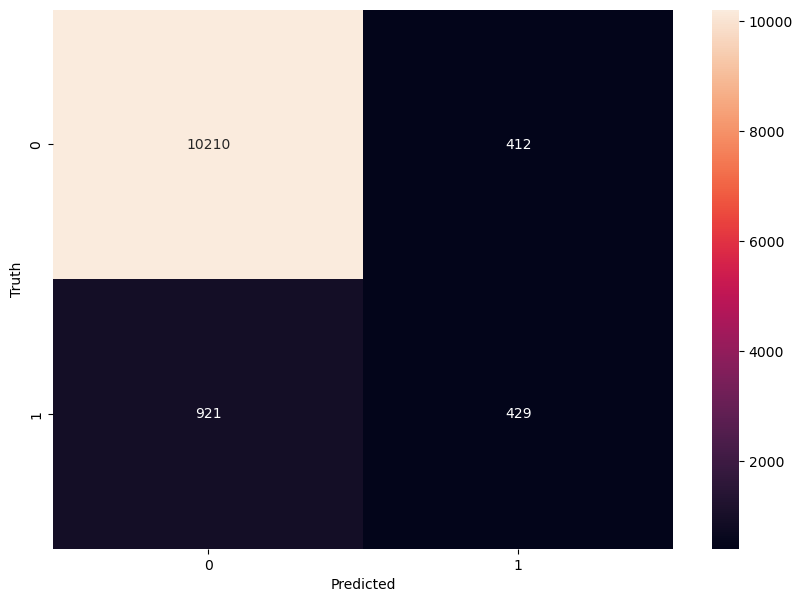

In [131]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [132]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11972,)
Number of ones in y_test_window: 1350


 17/375 [>.............................] - ETA: 1s

375/375 [==============================] - 1s 3ms/step


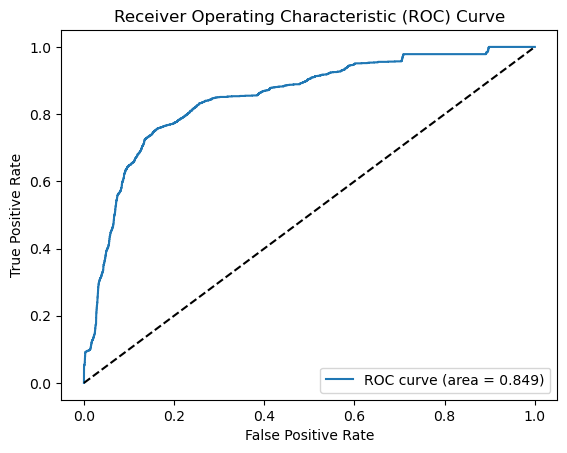

In [133]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [134]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

375/375 [==============================] - 1s 3ms/step
Best Threshold=0.121478, Sensitivity=0.750, Specificity=0.844, J=0.594
              precision    recall  f1-score   support

     healthy       0.96      0.84      0.90     10622
     failure       0.38      0.75      0.50      1350

    accuracy                           0.83     11972
   macro avg       0.67      0.80      0.70     11972
weighted avg       0.90      0.83      0.86     11972



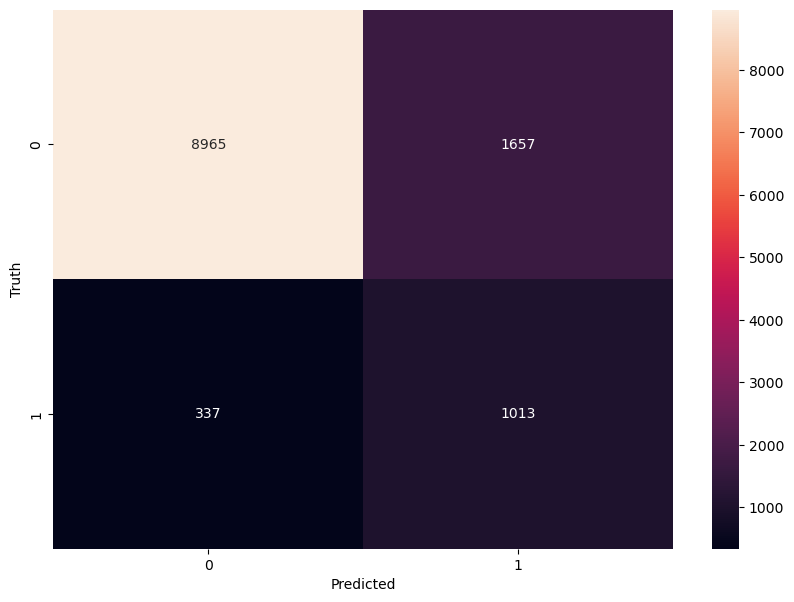

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Conv 1d + LSTM + Attention(window_size=30)

In [171]:
""" X_train_window = X_train_window.reshape(X_train_window.shape[0], 3, 10, X_train_window.shape[2])
X_val_window = X_val_window.reshape(X_val_window.shape[0], 3, 10, X_val_window.shape[2])
X_test_window = X_test_window.reshape(X_test_window.shape[0], 3, 10, X_test_window.shape[2]) """

In [172]:
""" print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape) """

(36698, 3, 10, 32)
(9100, 3, 10, 32)
(11238, 3, 10, 32)


In [105]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, timesteps, **kwargs):
        self.timesteps = timesteps
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(self.timesteps, 1),
                               initializer="zeros")     
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x*at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config.update({"timesteps": self.timesteps})
        return base_config

In [111]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

# 모델 정의input_shape=(None,30, 32)
def Conv1d_LSTM_Att_model(timestep):
    inputs = Input(shape=(timestep, 32))
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
    #x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    #x = Dropout(0.5)
    x = MaxPooling1D(pool_size=2)(x)
    #x = Flatten()(x)
    lstm_out = LSTM(32, return_sequences=True)(x)
    attention_out = Attention(14)(lstm_out)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention_out)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [112]:
model = Conv1d_LSTM_Att_model(30)

In [113]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('conv_lstm_att_30_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = Conv1d_LSTM_Att_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1058/1065 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.8826
Epoch 1: val_loss improved from inf to 0.31399, saving model to conv_lstm_att_30_best_model.h5
1065/1065 [==============================] - 10s 8ms/step - loss: 0.3572 - accuracy: 0.8827 - val_loss: 0.3140 - val_accuracy: 0.8864
Epoch 2/20
  27/1065 [..............................] - ETA: 6s - loss: 0.3446 - accuracy: 0.8796

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1057/1065 [============================>.] - ETA: 0s - loss: 0.3123 - accuracy: 0.8855
Epoch 2: val_loss did not improve from 0.31399
1065/1065 [==============================] - 7s 7ms/step - loss: 0.3119 - accuracy: 0.8856 - val_loss: 0.3285 - val_accuracy: 0.8885
Epoch 3/20
1061/1065 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8908
Epoch 3: val_loss improved from 0.31399 to 0.28839, saving model to conv_lstm_att_30_best_model.h5
1065/1065 [==============================] - 7s 7ms/step - loss: 0.2911 - accuracy: 0.8908 - val_loss: 0.2884 - val_accuracy: 0.8824
Epoch 4/20
1058/1065 [============================>.] - ETA: 0s - loss: 0.2821 - accuracy: 0.8930
Epoch 4: val_loss did not improve from 0.28839
1065/1065 [==============================] - 7s 6ms/step - loss: 0.2819 - accuracy: 0.8931 - val_loss: 0.3087 - val_accuracy: 0.8605
Epoch 5/20
1061/1065 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.8954
Epoch 5: val_loss did not i

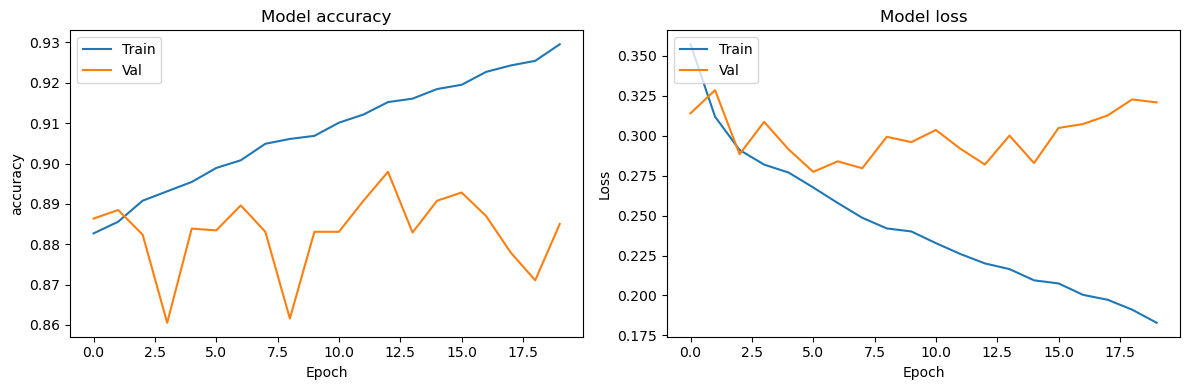

In [114]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [116]:
from keras.models import load_model

best_model = Conv1d_LSTM_Att_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('conv_lstm_att_30_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

375/375 [==============================] - 2s 3ms/step - loss: 0.2649 - accuracy: 0.8849


[0.26490625739097595, 0.8848980665206909]

In [117]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

375/375 [==============================] - 1s 2ms/step
Macro F1 Score: 0.6998766427141629


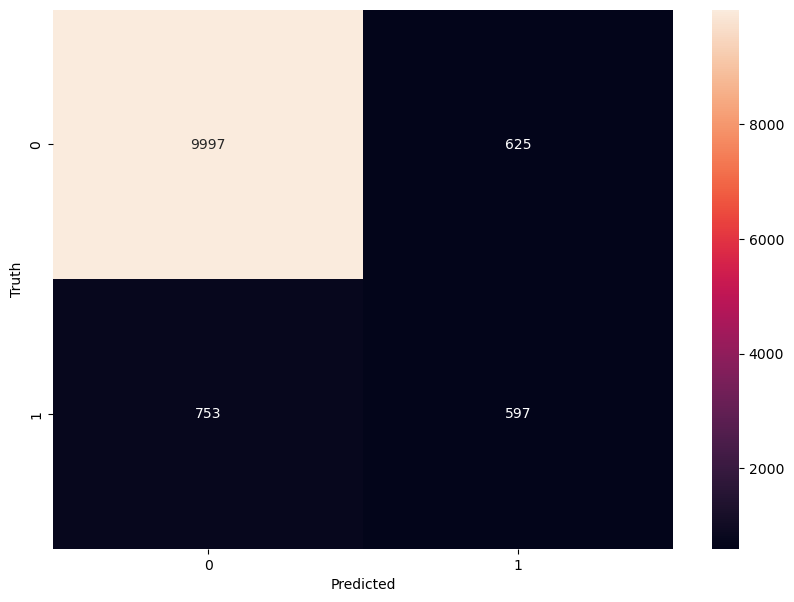

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [119]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11972,)
Number of ones in y_test_window: 1350


375/375 [==============================] - 1s 2ms/step


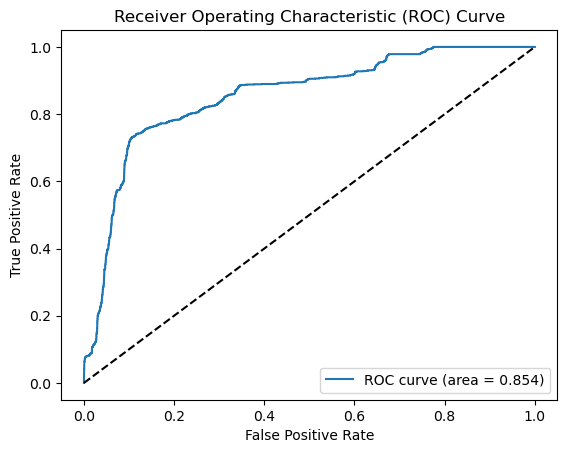

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [121]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

375/375 [==============================] - 1s 2ms/step
Best Threshold=0.275742, Sensitivity=0.732, Specificity=0.893, J=0.625
              precision    recall  f1-score   support

     healthy       0.96      0.89      0.93     10622
     failure       0.47      0.73      0.57      1350

    accuracy                           0.88     11972
   macro avg       0.71      0.81      0.75     11972
weighted avg       0.91      0.88      0.89     11972



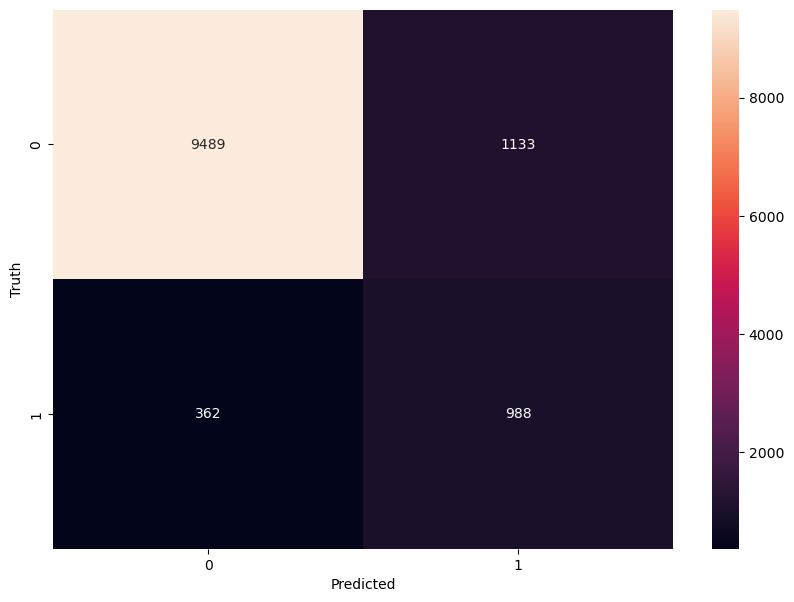

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## LSTM + Attention vs Conv1D + LSTM + Attention (window_size = 90)

### LSTM + Attention(window_size=90)

In [187]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
val_scaled = pd.concat([val_set[['disk_id','index']],X_val_scaled_df, y_val], axis=1)
test_scaled = pd.concat([test_set[['disk_id','index']],X_test_scaled_df, y_test], axis=1)

In [188]:
window_size = 90 # 10일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)

(19228, 90, 32)
(4719, 90, 32)
(5888, 90, 32)
(19228,)
(4719,)
(5888,)


In [192]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, timesteps, **kwargs):
        self.timesteps = timesteps
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(self.timesteps, 1),
                               initializer="zeros")     
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x*at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config.update({"timesteps": self.timesteps})
        return base_config

In [193]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

def LSTM_Att_model(timestep):
    inputs = Input(shape=(timestep, 32))
    lstm_out = LSTM(32, return_sequences=True)(inputs)
    attention_out = Attention(timestep)(lstm_out)
    x = Dense(32,  kernel_regularizer=regularizers.l2(0.001))(attention_out)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [194]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('LSTM_Att_90_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = LSTM_Att_model(90)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
601/601 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8644
Epoch 1: val_loss improved from inf to 0.33073, saving model to LSTM_Att_90_best_model.h5
601/601 [==============================] - 16s 23ms/step - loss: 0.3764 - accuracy: 0.8644 - val_loss: 0.3307 - val_accuracy: 0.8739
Epoch 2/20
  7/601 [..............................] - ETA: 11s - loss: 0.4672 - accuracy: 0.8170

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


599/601 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8638
Epoch 2: val_loss improved from 0.33073 to 0.29890, saving model to LSTM_Att_90_best_model.h5
601/601 [==============================] - 13s 22ms/step - loss: 0.3463 - accuracy: 0.8636 - val_loss: 0.2989 - val_accuracy: 0.8640
Epoch 3/20
600/601 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8643
Epoch 3: val_loss did not improve from 0.29890
601/601 [==============================] - 14s 23ms/step - loss: 0.3412 - accuracy: 0.8643 - val_loss: 0.3040 - val_accuracy: 0.8678
Epoch 4/20
600/601 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.8637
Epoch 4: val_loss improved from 0.29890 to 0.29780, saving model to LSTM_Att_90_best_model.h5
601/601 [==============================] - 14s 23ms/step - loss: 0.3265 - accuracy: 0.8636 - val_loss: 0.2978 - val_accuracy: 0.8733
Epoch 5/20
601/601 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 

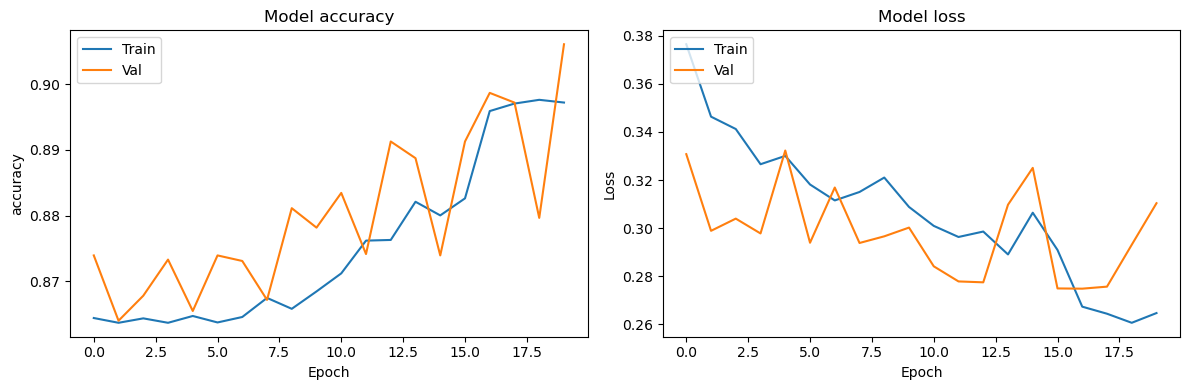

In [195]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [196]:
from keras.models import load_model

# LSTM 모델 정의
best_model = LSTM_Att_model(90)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('LSTM_Att_90_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

184/184 [==============================] - 2s 8ms/step - loss: 0.2698 - accuracy: 0.8972


[0.26982590556144714, 0.8972486257553101]

In [197]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

184/184 [==============================] - 2s 7ms/step
Macro F1 Score: 0.716588473852195


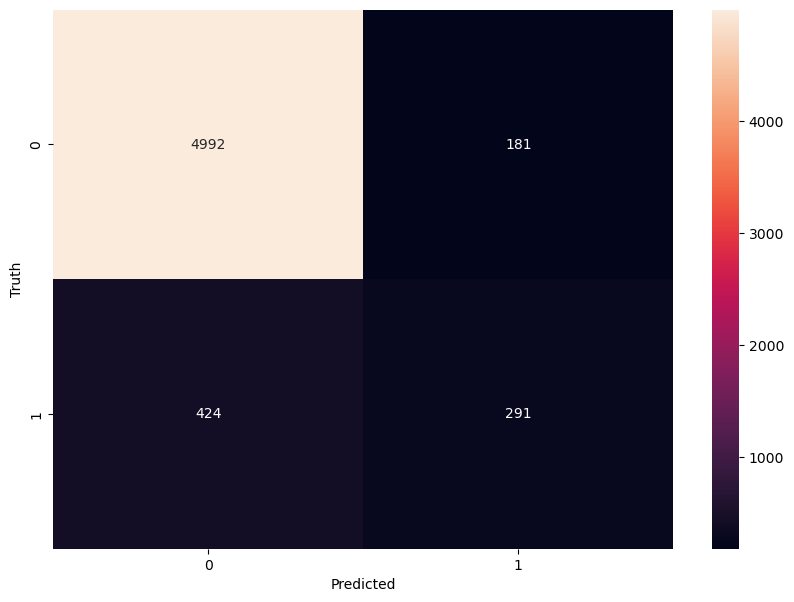

In [198]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [199]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(5888,)
Number of ones in y_test_window: 715


  1/184 [..............................] - ETA: 5s

184/184 [==============================] - 1s 8ms/step


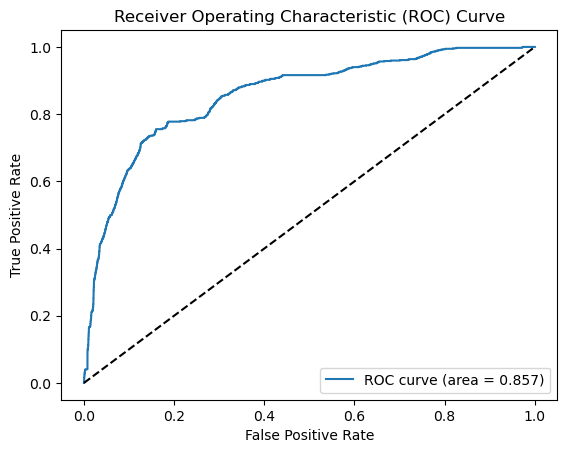

In [200]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [201]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

184/184 [==============================] - 1s 8ms/step
Best Threshold=0.117783, Sensitivity=0.755, Specificity=0.840, J=0.595
              precision    recall  f1-score   support

     healthy       0.96      0.84      0.90      5173
     failure       0.39      0.76      0.52       715

    accuracy                           0.83      5888
   macro avg       0.68      0.80      0.71      5888
weighted avg       0.89      0.83      0.85      5888



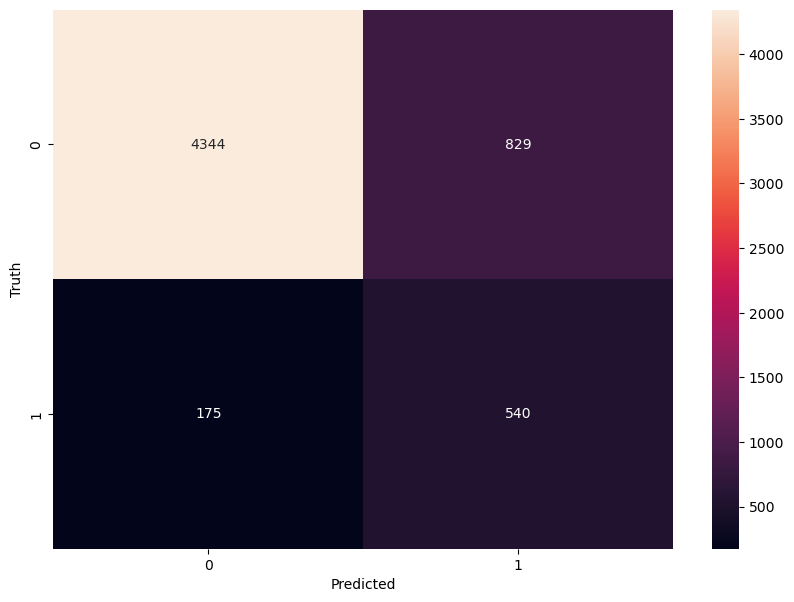

In [202]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Conv 1d + LSTM + Attention(windwo_size=90)

In [203]:
X_train_window = X_train_window.reshape(X_train_window.shape[0], 3, 30, X_train_window.shape[2])
X_val_window = X_val_window.reshape(X_val_window.shape[0], 3, 30, X_val_window.shape[2])
X_test_window = X_test_window.reshape(X_test_window.shape[0], 3, 30, X_test_window.shape[2])

In [204]:
print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

(19228, 3, 30, 32)
(4719, 3, 30, 32)
(5888, 3, 30, 32)


In [205]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('conv_lstm_att_90_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = Conv1d_LSTM_Att_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
595/601 [============================>.] - ETA: 0s - loss: 0.3623 - accuracy: 0.8649
Epoch 1: val_loss improved from inf to 0.30789, saving model to conv_lstm_att_90_best_model.h5
601/601 [==============================] - 8s 9ms/step - loss: 0.3621 - accuracy: 0.8648 - val_loss: 0.3079 - val_accuracy: 0.8739
Epoch 2/20
 22/601 [>.............................] - ETA: 4s - loss: 0.3871 - accuracy: 0.8480

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


595/601 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8683
Epoch 2: val_loss improved from 0.30789 to 0.28645, saving model to conv_lstm_att_90_best_model.h5
601/601 [==============================] - 5s 9ms/step - loss: 0.3257 - accuracy: 0.8678 - val_loss: 0.2864 - val_accuracy: 0.8815
Epoch 3/20
595/601 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8700
Epoch 3: val_loss did not improve from 0.28645
601/601 [==============================] - 6s 9ms/step - loss: 0.3160 - accuracy: 0.8698 - val_loss: 0.2977 - val_accuracy: 0.8767
Epoch 4/20
599/601 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8721
Epoch 4: val_loss did not improve from 0.28645
601/601 [==============================] - 5s 9ms/step - loss: 0.3034 - accuracy: 0.8722 - val_loss: 0.3052 - val_accuracy: 0.8841
Epoch 5/20
599/601 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8820
Epoch 5: val_loss improved from 0.28645 t

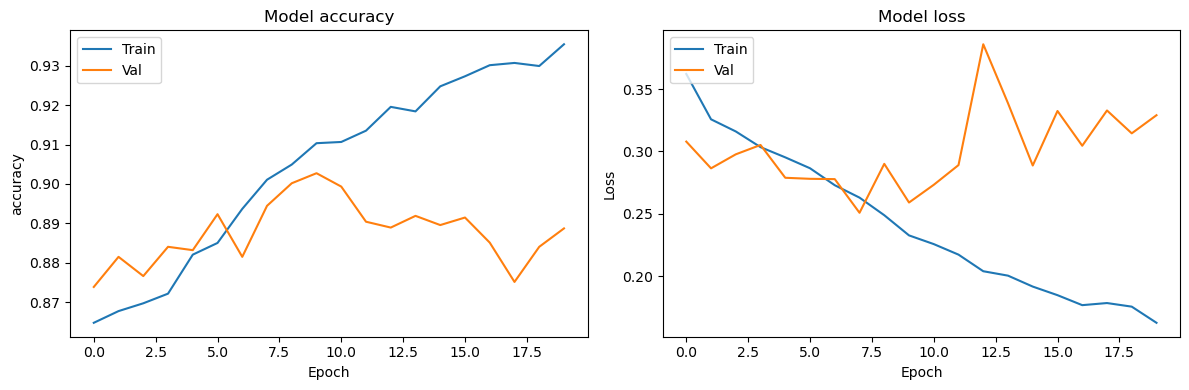

In [206]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [207]:
from keras.models import load_model

best_model = Conv1d_LSTM_Att_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('conv_lstm_att_90_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

184/184 [==============================] - 1s 4ms/step - loss: 0.2900 - accuracy: 0.8859


[0.28999441862106323, 0.885869562625885]

In [208]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

184/184 [==============================] - 1s 3ms/step
Macro F1 Score: 0.6896049553556719


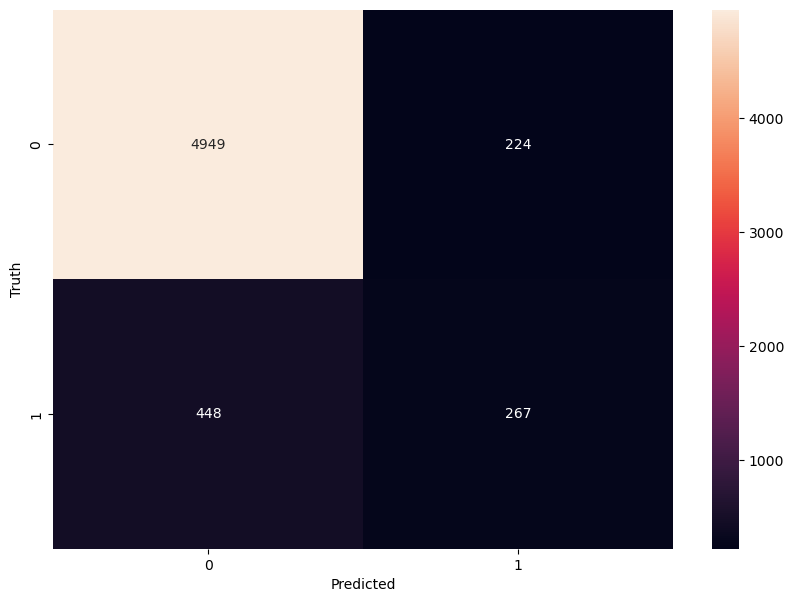

In [209]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [210]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(5888,)
Number of ones in y_test_window: 715


184/184 [==============================] - 1s 3ms/step


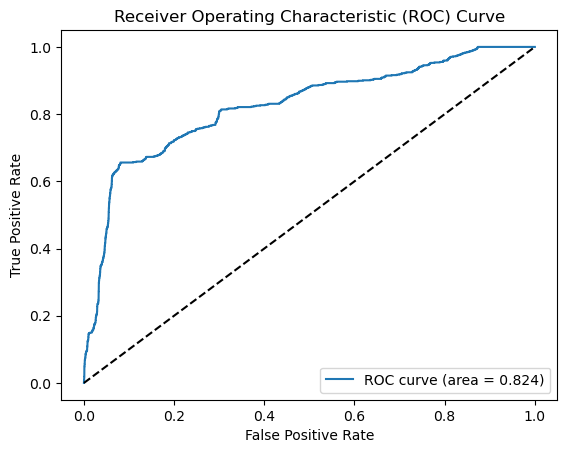

In [211]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [212]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

184/184 [==============================] - 1s 3ms/step
Best Threshold=0.237286, Sensitivity=0.656, Specificity=0.919, J=0.575
              precision    recall  f1-score   support

     healthy       0.95      0.92      0.93      5173
     failure       0.53      0.66      0.59       715

    accuracy                           0.89      5888
   macro avg       0.74      0.79      0.76      5888
weighted avg       0.90      0.89      0.89      5888



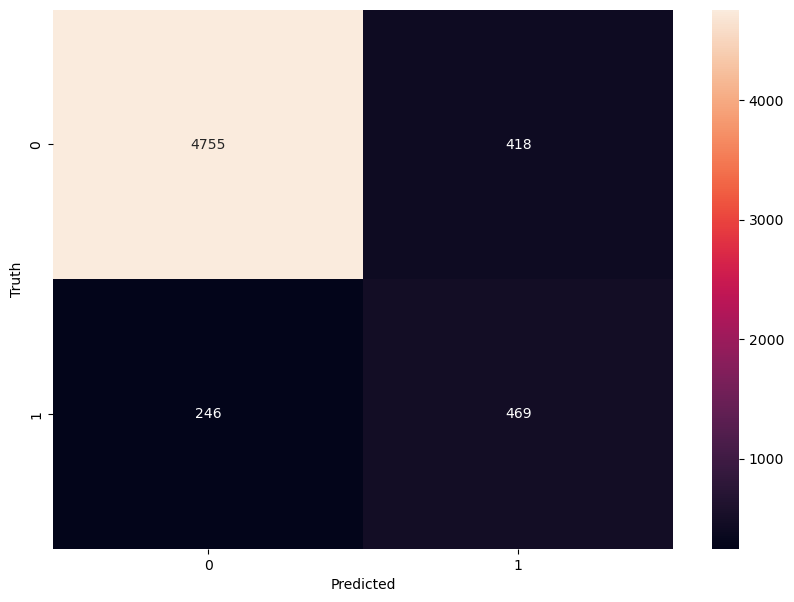

In [213]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## CNN + LSTM + SelfAttention? 만드는중,,,

In [359]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from keras import regularizers

inputs = Input(shape=(None, 30, 32))
x = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(inputs)
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Flatten())(x)
lstm_out = LSTM(32, return_sequences=True)(x)
attention_out = MultiHeadAttention(num_heads=10, key_dim=2)(lstm_out, lstm_out)
x = TimeDistributed(Dense(32, activation='relu'))(x)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [360]:
model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, None, 30, 32)]    0         
                                                                 
 time_distributed_121 (TimeD  (None, None, 28, 16)     1552      
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, None, 26, 32)     1568      
 istributed)                                                     
                                                                 
 time_distributed_123 (TimeD  (None, None, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_124 (TimeD  (None, None, 416)        0         
 istributed)                                              

In [361]:
# 학습
history = model.fit(final_X_train_window,final_y_trian_window,epochs=10, verbose=1,batch_size=32)

Epoch 1/10
744/744 [==============================] - 5s 6ms/step - loss: 0.3456 - accuracy: 0.8691
Epoch 2/10
744/744 [==============================] - 4s 6ms/step - loss: 0.3272 - accuracy: 0.8691
Epoch 3/10
744/744 [==============================] - 4s 6ms/step - loss: 0.3217 - accuracy: 0.8686
Epoch 4/10
744/744 [==============================] - 4s 6ms/step - loss: 0.3158 - accuracy: 0.8691
Epoch 5/10
744/744 [==============================] - 4s 5ms/step - loss: 0.3119 - accuracy: 0.8691
Epoch 6/10
744/744 [==============================] - 4s 5ms/step - loss: 0.3036 - accuracy: 0.8727
Epoch 7/10
744/744 [==============================] - 4s 5ms/step - loss: 0.2971 - accuracy: 0.8719
Epoch 8/10
744/744 [==============================] - 4s 5ms/step - loss: 0.2907 - accuracy: 0.8751
Epoch 9/10
744/744 [==============================] - 4s 6ms/step - loss: 0.2804 - accuracy: 0.8790
Epoch 10/10
744/744 [==============================] - 4s 6ms/step - loss: 0.2746 - accuracy: 0.8843

189/189 [==============================] - 0s 2ms/step


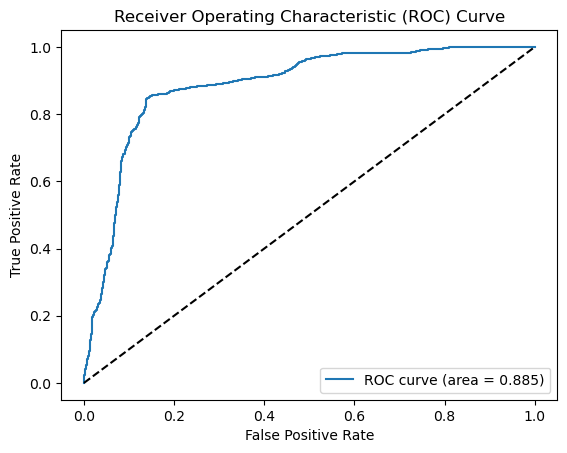

In [362]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [363]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# 이진 분류 문제의 경우, 임계값 0.1으로 설정하여 예측값을 0 또는 1로 변환
y_pred = (y_pred > 0.1).astype(int)

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

189/189 [==============================] - 0s 2ms/step
Macro F1 Score: 0.7585713682177979


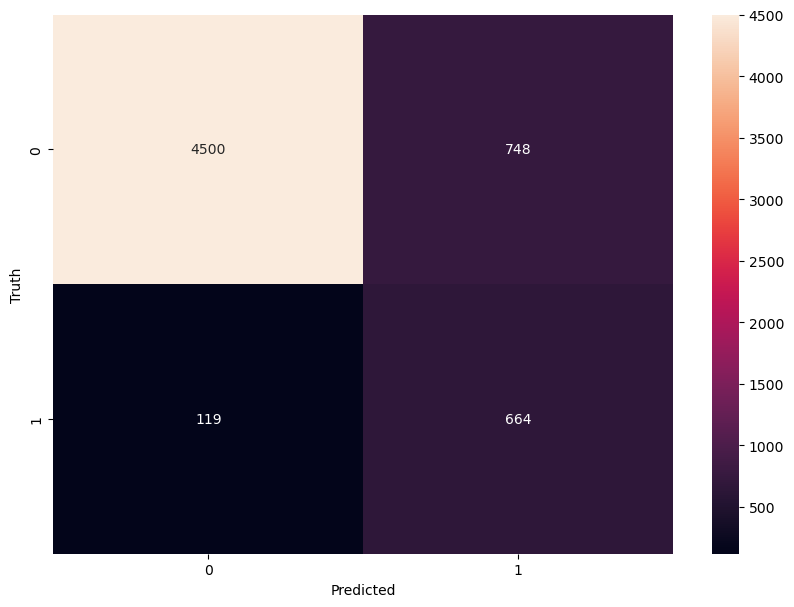

In [364]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [365]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

189/189 [==============================] - 0s 2ms/step
Best Threshold=0.103824, Sensitivity=0.845, Specificity=0.862, J=0.708
              precision    recall  f1-score   support

     healthy       0.97      0.86      0.91      5248
     failure       0.48      0.85      0.61       783

    accuracy                           0.86      6031
   macro avg       0.73      0.85      0.76      6031
weighted avg       0.91      0.86      0.88      6031



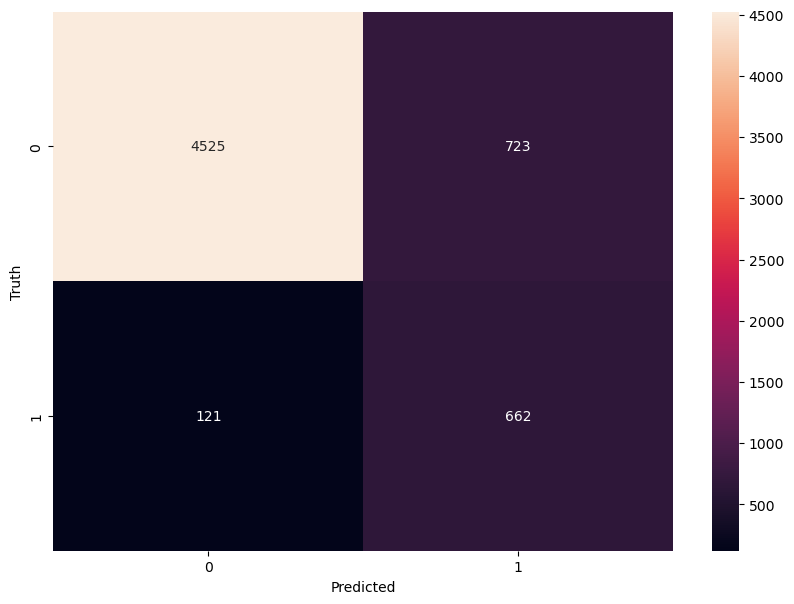

In [369]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [387]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from keras import regularizers

inputs = Input(shape=(None, 30, 32))
x = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(inputs)
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Flatten())(x)
lstm_out = LSTM(32, return_sequences=True)(x)
attention_out, attn_weights = MultiHeadAttention(num_heads=10, key_dim=2, return_attention_scores=True)(lstm_out, lstm_out)
x = TimeDistributed(Dense(32, activation='relu'))(attention_out)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = Dense(1, activation='sigmoid')(x)

mulheadatt_model = Model(inputs=inputs, outputs=[outputs, attn_weights])

mulheadatt_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: ('Keyword argument not understood:', 'return_attention_scores')

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D
from keras import regularizers

def LSTM_model(timestep):
    # LSTM 모델 정의
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(timestep, 32)))  # n_features는 특성의 수
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))  # n_features는 특성의 수
    model.add(LSTM(32))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

    return model

In [10]:
model = LSTM_model(30)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 28, 32)            3104      
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 64)            6208      
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 22817 (89.13 KB)
Trainable params: 22817 (89.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('LSTM+CONV!D_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = LSTM_model(30)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1143/1147 [============================>.] - ETA: 0s - loss: 0.3483 - acc: 0.8857
Epoch 1: val_loss improved from inf to 0.33146, saving model to LSTM+CONV!D_best_model.h5
1147/1147 [==============================] - 14s 10ms/step - loss: 0.3481 - acc: 0.8858 - val_loss: 0.3315 - val_acc: 0.8723
Epoch 2/20
  12/1147 [..............................] - ETA: 11s - loss: 0.3168 - acc: 0.8880

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1144/1147 [============================>.] - ETA: 0s - loss: 0.2923 - acc: 0.8913
Epoch 2: val_loss improved from 0.33146 to 0.31754, saving model to LSTM+CONV!D_best_model.h5
1147/1147 [==============================] - 12s 11ms/step - loss: 0.2924 - acc: 0.8912 - val_loss: 0.3175 - val_acc: 0.8715
Epoch 3/20
1147/1147 [==============================] - ETA: 0s - loss: 0.2735 - acc: 0.8929
Epoch 3: val_loss improved from 0.31754 to 0.29241, saving model to LSTM+CONV!D_best_model.h5
1147/1147 [==============================] - 12s 11ms/step - loss: 0.2735 - acc: 0.8929 - val_loss: 0.2924 - val_acc: 0.8743
Epoch 4/20
1147/1147 [==============================] - ETA: 0s - loss: 0.2623 - acc: 0.8955
Epoch 4: val_loss did not improve from 0.29241
1147/1147 [==============================] - 12s 10ms/step - loss: 0.2623 - acc: 0.8955 - val_loss: 0.3059 - val_acc: 0.8889
Epoch 5/20
1145/1147 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.8973
Epoch 5: val_loss improved fr

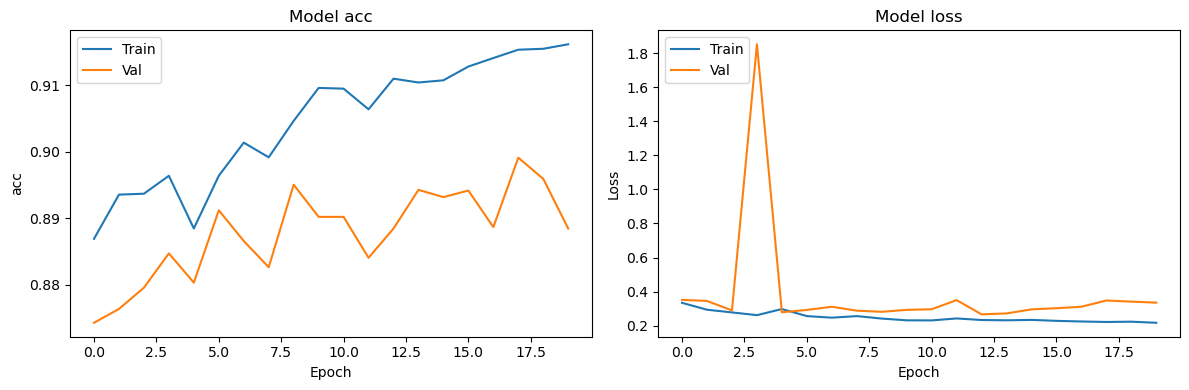

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation acc values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from keras.models import load_model

# LSTM 모델 정의
best_model = LSTM_model(30)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

352/352 [==============================] - 1s 3ms/step - loss: 0.2886 - acc: 0.8876


[0.2886417806148529, 0.8876134753227234]

In [ ]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

352/352 [==============================] - 1s 3ms/step
Macro F1 Score: 0.7009104622654379


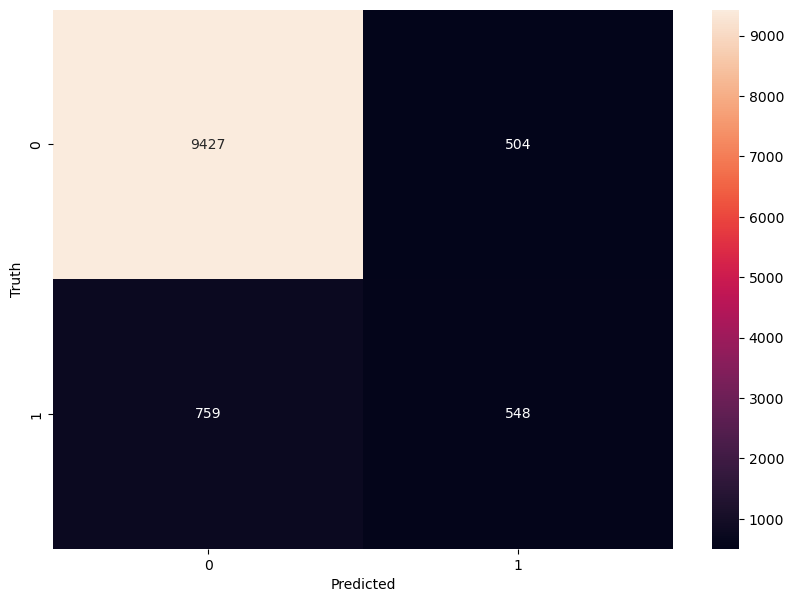

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11238,)
Number of ones in y_test_window: 1307


  1/352 [..............................] - ETA: 7s

352/352 [==============================] - 1s 3ms/step


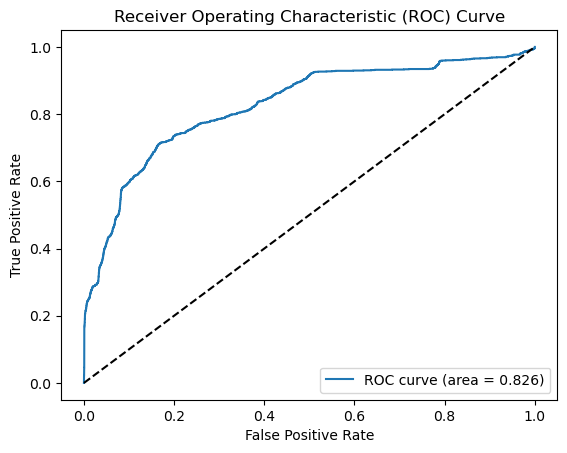

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()